In [17]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

In [18]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1274.099976,1288.599976,1271.000000,1278.800049,1278.800049,823
2017-12-04,1272.500000,1276.099976,1270.300049,1274.300049,1274.300049,850
2017-12-05,1275.400024,1275.800049,1260.000000,1261.599976,1261.599976,1499
2017-12-06,1264.900024,1267.800049,1261.599976,1262.800049,1262.800049,373
2017-12-07,1262.300049,1262.400024,1243.900024,1249.800049,1249.800049,358
...,...,...,...,...,...,...
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343


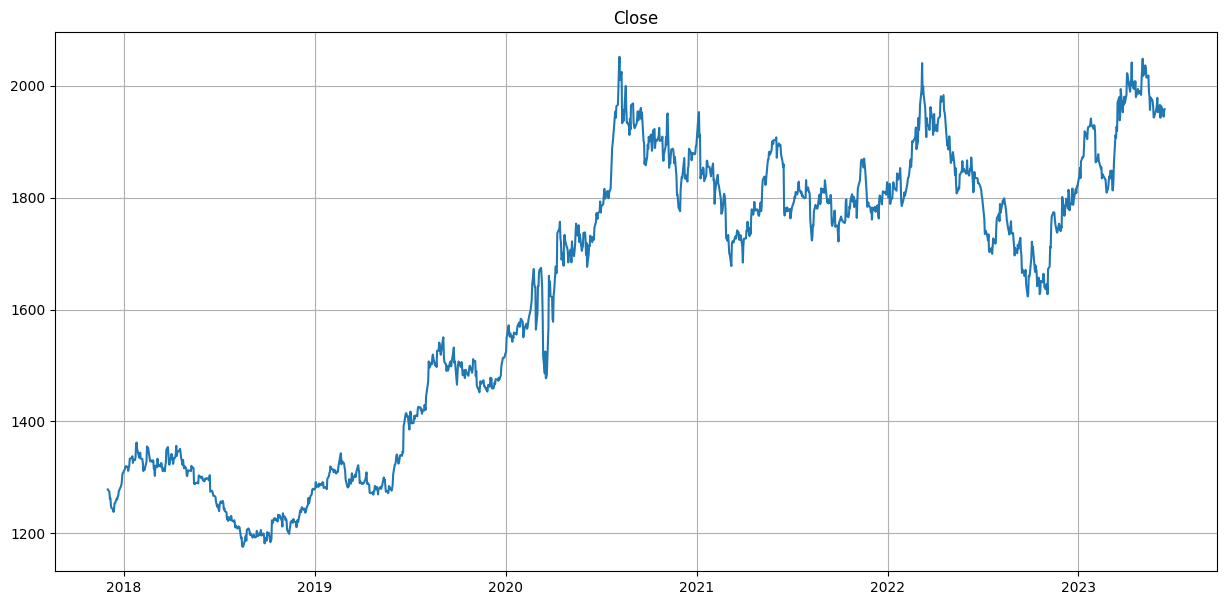

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(data['Close'])
plt.title('Close')
plt.grid(True)
plt.show()

In [20]:
data = data.reset_index('Date', inplace=False)

In [21]:
# 4. Split train test
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [22]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [23]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [25]:
simple_exp = ExponentialSmoothing(trend=None, seasonal=None)

In [26]:
#5. Fit model with train data
simple_exp.fit(y_train)

ExponentialSmoothing()

In [27]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [28]:
y_pred = simple_exp.predict(test_data.index)

In [29]:
y_pred_val= simple_exp.predict(val_data.index)

In [30]:
#8. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = simple_exp.predict(fh)

In [31]:
# 9. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 95.78949345578118
Validation RMSE: 165.03523916860217
Testing MAE: 77.4234990437735
Validation MAE: 144.2693447676003
Testing MAPE: 0.0423305698860409
Validation MAPE: 0.07393076855196452


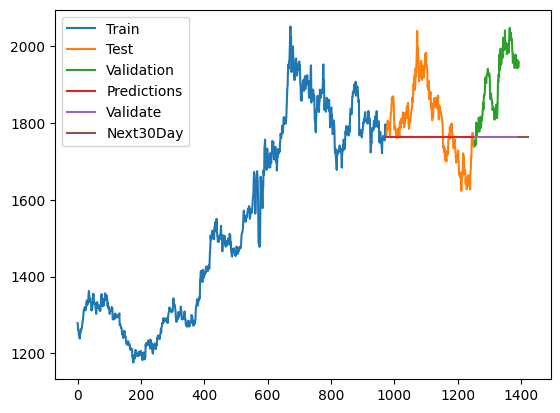

In [33]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

In [34]:
double_exp = ExponentialSmoothing(trend="add", seasonal=None)

In [35]:
#5. Fit model with train data
double_exp.fit(y_train)

ExponentialSmoothing(trend='add')

In [36]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
#y_pred = model.predict(n_periods=len(y_test))

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
#y_pred_val =  model.predict(n_periods=len(y_val))

In [37]:
y_pred = double_exp.predict(test_data.index)

In [38]:
y_pred_val= double_exp.predict(val_data.index)

In [39]:
#8. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = double_exp.predict(fh)

In [40]:
# 9. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 563.7421300044975
Validation RMSE: 763.9553278037351
Testing MAE: 555.5064130661592
Validation MAE: 759.2578116223062
Testing MAPE: 0.30724841475948983
Validation MAPE: 0.3964761283199721


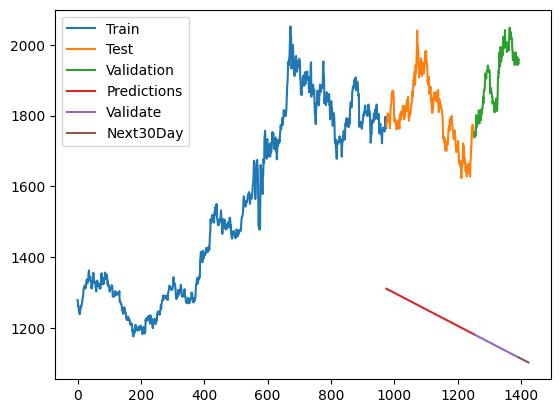

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()